In [1]:
import glob
import cv2
import numpy as np
import os
import shutil
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import random
import re

In [2]:
# シードを固定する関数
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# シードを固定
set_seed(42)

In [3]:
def make_models(model_paths):
        
    class DeepAutoencoder(nn.Module):
        def __init__(self):
            super(DeepAutoencoder, self).__init__()
            self.Encoder = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 256 -> 128
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 128 -> 64
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 64 -> 32
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 32 -> 16
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # 16 -> 8
            )
            self.Decoder = nn.Sequential(
                nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # 8 -> 16
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # 16 -> 32
                nn.ReLU(),
                nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # 32 -> 64
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 64 -> 128
                nn.ReLU(),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2),  # 128 -> 256
                nn.ReLU(),
                nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
            )

        def forward(self, x):
            x = self.Encoder(x)
            x = self.Decoder(x)
            return x
    
    models = []
    for model_path in model_paths:
        model = DeepAutoencoder().cuda()
        model.load_state_dict(torch.load(model_path))
        models.append(model)
    return models

In [4]:
# 画像分割サイズ
distance = 224

# 画像を分割する関数
def split(FILES):
    # 分割後の画像を分割前の画像ごとに格納
    split_images = []
    for i in range(len(FILES)):
        file = FILES[i]  # ファイル名
        img = Image.open(file)  # 画像読み込み
        img = np.array(img)  # Pillowの画像をnumpy配列に変換
        h, w = img.shape[:2]  # 画像のサイズ
        # 分割の始点
        cx = 0
        cy = 0
        for x in range(h // distance):
            for y in range(w // distance):
                # 画像の切り取り
                split_img = img[cx:cx + distance, cy:cy + distance]
                # 画像の格納
                split_images.append(Image.fromarray(split_img))  # numpy配列をPillowの画像に変換して格納
                cy += distance
            cy = 0
            cx += distance
    return split_images

In [5]:
def AE(IMGS, model_paths, threshold, noise_kernel_size=5, morph_kernel_size=5, use_morphology=False, normalize=False):
    models = make_models(model_paths)
    prepocess = T.Compose([T.ToTensor()])
    diff_mse_lists = []
    diff_mse_mean_list = []
    model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]

    for _ in models:
        diff_mse_lists.append([])
    # 一番最後の_の次のアルファベットを取得
    last_chars = [name.split('_')[-1][0] for name in model_names]

    # result_dirを作成
    result_dir = f'imgs/diffmse_mean_{"".join(last_chars)}_search_result'

    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

    # 各サブフォルダを作成
    suffix = f"noise_kernel_{noise_kernel_size}"
    if use_morphology:
        suffix += f"_morph_kernel_{morph_kernel_size}"
    else:
        suffix += "_no_morph"
    if normalize:
        suffix += "_norm"
    else:
        suffix += "_nonorm"

    diff_img_dir = os.path.join(result_dir, 'new_diff_img')
    binary_img_dir = os.path.join(result_dir, f'{threshold}_new_binary_img_{suffix}')
    output_img_dir = os.path.join(result_dir, f'new_output_img')
    input_img_dir = os.path.join(result_dir, 'new_input_img')
    gray_diff_img_dir = os.path.join(result_dir, 'new_gray_diff_img')
    norm_diff_img_dir = os.path.join(result_dir, 'new_norm_diff_img')
    contour_img_dir = os.path.join(result_dir, f'{threshold}_new_contour_img_{suffix}')
    combined_img_dir = os.path.join(result_dir, f'{threshold}_combined_img_{suffix}')

    if not os.path.exists(diff_img_dir):
        os.makedirs(diff_img_dir)
    if not os.path.exists(contour_img_dir):
        os.makedirs(contour_img_dir)
    if not os.path.exists(binary_img_dir):
        os.makedirs(binary_img_dir)
    if not os.path.exists(output_img_dir):
        os.makedirs(output_img_dir)
    if not os.path.exists(input_img_dir):
        os.makedirs(input_img_dir)
    if not os.path.exists(combined_img_dir):
        os.makedirs(combined_img_dir)
    if not os.path.exists(gray_diff_img_dir):
        os.makedirs(gray_diff_img_dir)
    if not os.path.exists(norm_diff_img_dir):
        os.makedirs(norm_diff_img_dir)

    for img_idx, IMG in enumerate(IMGS):
        diff_list = []
        max_areas = []
        for model_idx, model in enumerate(models):
            model.eval()
            model_diff_dir = os.path.join(diff_img_dir, model_names[model_idx])  # モデルの順番をフォルダ名に使用
            model_contour_dir = os.path.join(contour_img_dir, model_names[model_idx])  # 輪郭画像の保存先フォルダ
            model_binary_dir = os.path.join(binary_img_dir, model_names[model_idx])  # 二値化画像の保存先フォルダ
            model_output_dir = os.path.join(output_img_dir, model_names[model_idx])  # output画像の保存先フォルダ
            model_input_dir = os.path.join(input_img_dir, model_names[model_idx])  # input画像の保存先フォルダ
            model_gray_diff_dir = os.path.join(gray_diff_img_dir, model_names[model_idx])  # グレースケールdiff画像の保存先フォルダ
            model_norm_diff_dir = os.path.join(norm_diff_img_dir, model_names[model_idx])  # 正規化diff画像の保存先フォルダ

            # モデル順のフォルダを作成
            if not os.path.exists(model_diff_dir):
                os.makedirs(model_diff_dir)
            if not os.path.exists(model_contour_dir):
                os.makedirs(model_contour_dir)
            if not os.path.exists(model_binary_dir):
                os.makedirs(model_binary_dir)
            if not os.path.exists(model_output_dir):
                os.makedirs(model_output_dir)
            if not os.path.exists(model_input_dir):
                os.makedirs(model_input_dir)
            if not os.path.exists(model_gray_diff_dir):
                os.makedirs(model_gray_diff_dir)
            if not os.path.exists(model_norm_diff_dir):
                os.makedirs(model_norm_diff_dir)

            img_tensor = prepocess(IMG).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img_tensor)[0]
            output = output.cpu().numpy().transpose(1, 2, 0)
            output = np.uint8(np.maximum(np.minimum(output * 255, 255), 0))
            origin = np.uint8(img_tensor[0].cpu().numpy().transpose(1, 2, 0) * 255)
            diff = np.uint8(np.sqrt((output.astype(np.float32) - origin.astype(np.float32)) ** 2))
            diff_mse = np.uint8((output.astype(np.float32) - origin.astype(np.float32)) ** 2)
            diff_mse = np.sum(diff_mse)
            diff_mse_sum = diff_mse / (224 * 224 * 3)
            diff_mse_lists[model_idx].append(diff_mse_sum)

            # 画像の保存
            img_counter = img_idx + 1  # 順番をカウンターとして使用
            diff_path = os.path.join(model_diff_dir, f"{diff_mse_sum}_{img_counter}_{model_names[model_idx]}.png")
            output_path = os.path.join(model_output_dir, f"{img_counter}_{model_names[model_idx]}.png")
            binary_path = os.path.join(model_binary_dir, f"{img_counter}_{model_names[model_idx]}.png")
            contour_img_path = os.path.join(model_contour_dir, f"{img_counter}_{model_names[model_idx]}.png")
            input_path = os.path.join(model_input_dir, f"{img_counter}.png")
            gray_diff_path = os.path.join(model_gray_diff_dir, f"{img_counter}_{model_names[model_idx]}.png")
            norm_diff_path = os.path.join(model_norm_diff_dir, f"{img_counter}_{model_names[model_idx]}.png")

            cv2.imwrite(diff_path, diff)

            # output画像を保存（RGBからBGRに変換）
            output_img = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
            cv2.imwrite(output_path, output_img)

            # 入力画像を保存（RGBからBGRに変換）
            input_img = cv2.cvtColor(np.array(IMG), cv2.COLOR_RGB2BGR)
            cv2.imwrite(input_path, input_img)

            # 差分画像をグレースケールに変換
            gray_diff = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

            # グレースケールdiff画像を保存
            cv2.imwrite(gray_diff_path, gray_diff)

            # 差分画像の値の範囲を確認
            min_val, max_val, _, _ = cv2.minMaxLoc(gray_diff)
            # print(f"Diff image min value: {min_val}, max value: {max_val}")

            # 差分画像を正規化するかどうか
            if normalize:
                norm_diff = cv2.normalize(gray_diff, None, 0, 255, cv2.NORM_MINMAX)
            else:
                norm_diff = gray_diff

            # 正規化diff画像を保存
            cv2.imwrite(norm_diff_path, norm_diff)

            # 二値化
            _, binary = cv2.threshold(norm_diff, threshold, 255, cv2.THRESH_BINARY)

            # 二値化画像を保存
            cv2.imwrite(binary_path, binary)

            # ノイズ除去のカーネル
            noise_kernel = np.ones((noise_kernel_size, noise_kernel_size), np.uint8)
            bin_img = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, noise_kernel)

            if use_morphology:
                # 輪郭抽出(拡張収縮を行う場合)
                morph_kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)  # カーネルサイズを大きくして輪郭を補完
                bin_img = cv2.dilate(bin_img, morph_kernel, iterations=2)  # 膨張処理を追加
                bin_img = cv2.erode(bin_img, morph_kernel, iterations=2)  # 収縮処理を追加

            # 輪郭抽出
            contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)  # 面積順にソート

            # 最大の物体の面積を取得
            max_area = cv2.contourArea(contours[0]) if contours else 0
            max_areas.append(max_area)

            # 輪郭を塗りつぶし
            contour_img = np.zeros((diff.shape[0], diff.shape[1], 3), dtype=np.uint8)  # 正しい形式で初期化
            for contour in contours:
                color = [random.randint(0, 255) for _ in range(3)]  # ランダムな色を生成
                cv2.drawContours(contour_img, [contour], -1, color, cv2.FILLED)  # ランダムな色で輪郭を塗りつぶし

            # 輪郭画像を保存
            contour_img_path = os.path.join(model_contour_dir, f"{max_area:.2f}_{img_counter}_{model_names[model_idx]}.png")
            cv2.imwrite(contour_img_path, contour_img)

        # 入力画像と対応するモデルの数分の輪郭画像を横に並べる
        input_img = Image.open(input_path)
        combined_width = input_img.width * 4  # 4列で切り替える
        combined_height = input_img.height * ((len(models) + len(models)//3) // 4)  # 行数を計算
        combined_img = Image.new('RGB', (combined_width, combined_height))

        # 入力画像を左端に配置
        for row in range((len(models) + len(models)//3) // 4):
            combined_img.paste(input_img, (0, input_img.height * row))

        # 輪郭画像を順に配置
        for model_idx in range(len(models)):
            row = model_idx // 3
            col = (model_idx % 3) + 1
            contour_img_path = os.path.join(contour_img_dir, model_names[model_idx], f"{max_areas[model_idx]:.2f}_{img_counter}_{model_names[model_idx]}.png")
            contour_img = Image.open(contour_img_path)
            combined_img.paste(contour_img, (input_img.width * col, input_img.height * row))

            # 画像の上にモデル番号、最大面積、ノイズ除去カーネルサイズ、二値化閾値、正規化の有無を明記
            draw = ImageDraw.Draw(combined_img)
            font = ImageFont.load_default()
            text_position = (input_img.width * col + 10, input_img.height * row + 10)
            draw.text(text_position, f"{model_names[model_idx]}", fill=(255, 255, 255), font=font)
            text_position = (input_img.width * col + 10, input_img.height * row + 30)
            draw.text(text_position, f"Max Area: {max_areas[model_idx]:.2f}", fill=(255, 255, 255), font=font)
            text_position = (input_img.width * col + 10, input_img.height * row + 50)
            draw.text(text_position, f"Noise Kernel Size: {noise_kernel_size}", fill=(255, 255, 255), font=font)
            if use_morphology:
                text_position = (input_img.width * col + 10, input_img.height * row + 70)
                draw.text(text_position, f"Morph Kernel Size: {morph_kernel_size}", fill=(255, 255, 255), font=font)
            text_position = (input_img.width * col + 10, input_img.height * row + 90)
            draw.text(text_position, f"Threshold: {threshold}", fill=(255, 255, 255), font=font)
            text_position = (input_img.width * col + 10, input_img.height * row + 110)
            draw.text(text_position, f"Normalize: {'Yes' if normalize else 'No'}", fill=(255, 255, 255), font=font)

        # 結合画像を保存
        combined_img_path = os.path.join(combined_img_dir, f"{img_counter}.png")
        combined_img.save(combined_img_path)
    
    for mse_list in diff_mse_lists:
        diff_mse_mean= np.mean(mse_list)
        diff_mse_mean_list.append(diff_mse_mean)

    return diff_mse_mean_list

In [6]:
def AE2(model_paths, model_folder_map):
    models = make_models(model_paths)  # モデルをロード
    preprocess = T.Compose([T.ToTensor()])  # 前処理
    diff_mse_mean_list = []
    model_names = [os.path.splitext(os.path.basename(path))[0] for path in model_paths]

    # モデルに対応する画像フォルダを準備
    folder_keys = [name.split('_')[-1] for name in model_names]  # '_ddark', '_dlight' などを取得
    img_folders = [model_folder_map.get(key, None) for key in folder_keys]

    # 対応するフォルダがすべて存在するかチェック
    for folder in img_folders:
        if not folder or not os.path.exists(folder):
            raise ValueError(f"対応する画像フォルダが見つかりません: {folder}")

    for model_idx, model in enumerate(models):
        model.eval()
        diff_mse_list = []
        folder = img_folders[model_idx]  # モデルに対応する画像フォルダ
        images = glob.glob(os.path.join(folder, "*"))

        # 画像を分割
        split_images = split(images)

        # 各分割画像に対して処理
        for img in split_images:
            img_tensor = preprocess(img).unsqueeze(0).cuda()
            with torch.no_grad():
                output = model(img_tensor)[0]
            output = output.cpu().numpy().transpose(1, 2, 0)
            output = np.uint8(np.maximum(np.minimum(output * 255, 255), 0))
            origin = np.uint8(img_tensor[0].cpu().numpy().transpose(1, 2, 0) * 255)
            diff_mse = ((output.astype(np.float32) - origin.astype(np.float32)) ** 2)
            diff_mse_sum = np.sum(diff_mse) / (224 * 224 * 3)
            diff_mse_list.append(diff_mse_sum)

        # 平均MSEを計算
        if diff_mse_list:
            diff_mse_mean = np.mean(diff_mse_list)
            diff_mse_mean_list.append(diff_mse_mean)
        else:
            diff_mse_mean_list.append(None)

    return diff_mse_mean_list

In [7]:
# コピー元のモデルファイル
model_paths = [
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_ddark.pth",
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_dlight.pth",
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_dwhite.pth"
]

# コピー先のディレクトリ
dest_dir = "models/d_finemodels_100_5000"
new_dest_dir = "models/d_finemodels_100_6048"

# コピー先のディレクトリが存在しない場合は作成
if not os.path.exists(new_dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    # モデルファイルをコピー
    for model_path in model_paths:
        shutil.copy(model_path, dest_dir)
    # ディレクトリ名を変更
    os.rename(dest_dir, new_dest_dir)
    print(f"モデルファイルを{new_dest_dir}にコピーし、ディレクトリ名を変更しました。")
else:
    print(f"{new_dest_dir} は既に存在します。次のセルを実行してください。")

models/d_finemodels_100_6048 は既に存在します。次のセルを実行してください。


In [8]:
# コピー元のモデルファイル
model_paths = [
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_rdark.pth",
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_rlight.pth",
    "models/fine_model_paths/6048_fineAEdeepmodel_20241227_rwhite.pth"
]

# コピー先のディレクトリ
dest_dir = "models/r_finemodels_100_5000"
new_dest_dir = "models/r_finemodels_100_6048"

# コピー先のディレクトリが存在しない場合は作成
if not os.path.exists(new_dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    # モデルファイルをコピー
    for model_path in model_paths:
        shutil.copy(model_path, dest_dir)
    # ディレクトリ名を変更
    os.rename(dest_dir, new_dest_dir)
    print(f"モデルファイルを{new_dest_dir}にコピーし、ディレクトリ名を変更しました。")
else:
    print(f"{new_dest_dir} は既に存在します。次のセルを実行してください。")

models/r_finemodels_100_6048 は既に存在します。次のセルを実行してください。


In [9]:
# グラフ描画用関数
def plot_mse_trends(model_paths, mse_lists, title):
    sizes = []
    types = []
    for path in model_paths:
        match = re.search(r'(\d+)_fineAEdeepmodel_.*_(d\w+|r\w+)\.pth', path)
        if match:
            sizes.append(int(match.group(1)))
            types.append(match.group(2))

    # 種類ごとにデータを整理
    type_mse_map = {}
    for size, type_, mse in zip(sizes, types, mse_lists):
        if type_ not in type_mse_map:
            type_mse_map[type_] = {'sizes': [], 'mses': []}
        type_mse_map[type_]['sizes'].append(size)
        type_mse_map[type_]['mses'].append(mse)

    # プロット
    plt.figure(figsize=(10, 6))
    for type_, data in type_mse_map.items():
        sizes_sorted, mses_sorted = zip(*sorted(zip(data['sizes'], data['mses'])))
        plt.plot(sizes_sorted, mses_sorted, marker='o', label=type_)
        for x, y in zip(sizes_sorted, mses_sorted):
            plt.text(x, y, f'{y:.2f}', fontsize=8, ha='right', va='bottom')

    # グラフの設定
    plt.title(title)
    plt.xlabel('Model Size')
    plt.ylabel('Mean MSE')
    plt.legend(title='Model Type')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    # 表示
    plt.show()

In [10]:
d_model_paths = list(glob.glob("models/d_finemodels_100_6048/*"))
r_model_paths = list(glob.glob("models/r_finemodels_100_6048/*"))
# 数字の大きさでソート
d_model_paths = sorted(d_model_paths, key=lambda x: int(x.split('/')[2].split('_')[0]))
r_model_paths = sorted(r_model_paths, key=lambda x: int(x.split('/')[2].split('_')[0]))
# 数字の大きさでソートした後、アルファベットでソート
d_model_paths = sorted(d_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))
r_model_paths = sorted(r_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))
threshold = 30
files = list(glob.glob("imgs/test_img/*.JPG"))
split_images = split(files)
d_mse_lists= AE(split_images,d_model_paths,threshold, noise_kernel_size=3, morph_kernel_size=0, use_morphology=False, normalize=False)
r_mse_lists= AE(split_images,r_model_paths,threshold, noise_kernel_size=3, morph_kernel_size=0, use_morphology=False, normalize=False)

/tmp/ipykernel_2291567/309347958.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


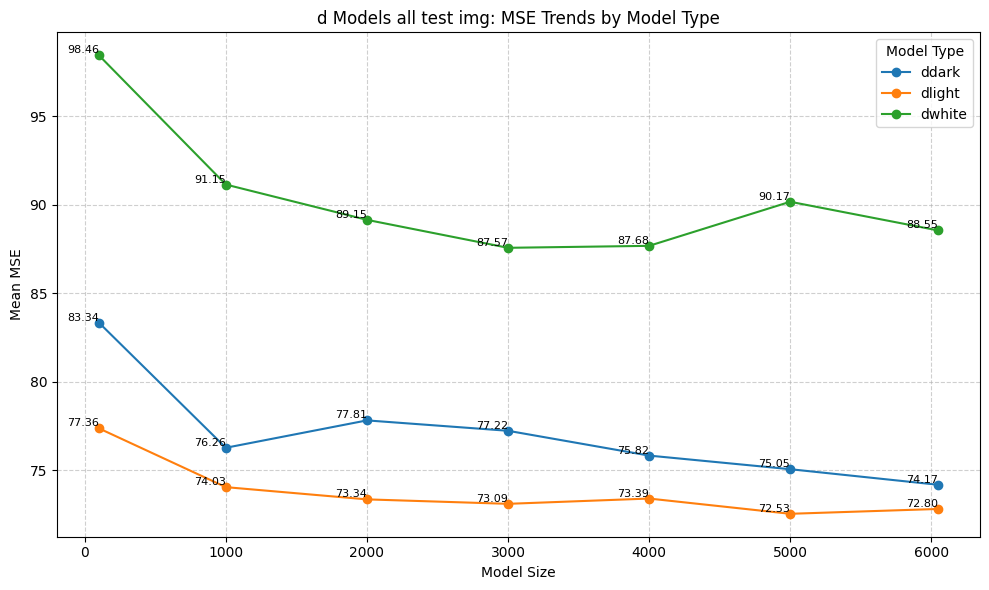

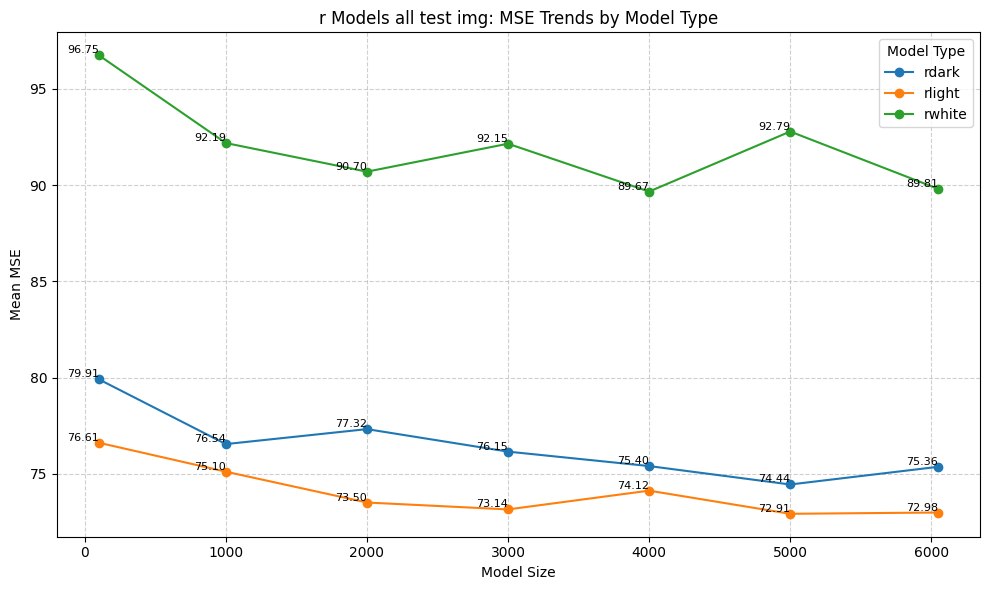

In [11]:
plot_mse_trends(d_model_paths, d_mse_lists, 'd Models all test img: MSE Trends by Model Type')
plot_mse_trends(r_model_paths, r_mse_lists, 'r Models all test img: MSE Trends by Model Type')

In [12]:
# 実行コード
# モデルとフォルダの対応表を作成
model_folder_map = {
    'dwhite': 'imgs/test_img2/yes/white',
    'dlight': 'imgs/test_img2/yes/light',
    'ddark': 'imgs/test_img2/yes/dark',
    'rwhite': 'imgs/test_img2/yes/white',
    'rlight': 'imgs/test_img2/yes/light',
    'rdark': 'imgs/test_img2/yes/dark',
}

# モデルパスを取得してソート
d_model_paths = list(glob.glob("models/d_finemodels_100_6048/*"))
r_model_paths = list(glob.glob("models/r_finemodels_100_6048/*"))
d_model_paths = sorted(d_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))
r_model_paths = sorted(r_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))

# AE2を使用して実行
d_yes_mse_lists = AE2(d_model_paths, model_folder_map)
r_yes_mse_lists = AE2(r_model_paths, model_folder_map)

# 結果を出力
print("D Models MSE Lists:", d_yes_mse_lists)
print("R Models MSE Lists:", r_yes_mse_lists)

/tmp/ipykernel_2291567/309347958.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


D Models MSE Lists: [247.53582137542514, 431.62951171875, 374.0186896789966, 221.22959130527212, 388.7112032312925, 214.28590129411134, 217.99418878879675, 381.8320837983631, 198.6087968351403, 211.66483876753827, 391.3862431574193, 194.8758045014881, 210.86357375372023, 374.75061696162845, 182.26914089073128, 207.86178020036138, 381.46481744260194, 236.38193405877976, 205.59765611713436, 374.14692024075265, 194.8245238095238]
R Models MSE Lists: [237.79942841198977, 422.44756317761477, 292.3386588541667, 218.5762956393495, 399.0998584316539, 239.29955370429423, 215.9866842713648, 378.9758581792092, 211.84745077327807, 209.95713196215988, 391.361915191858, 253.69951982355443, 210.3960397401148, 378.69050502232136, 199.99288438031465, 206.11009068080355, 387.583297791773, 274.9330553119686, 205.40032651732565, 372.36252903114377, 206.97502989477042]


In [13]:
# 実行コード
# モデルとフォルダの対応表を作成
model_folder_map = {
    'dwhite': 'imgs/test_img2/no/white',
    'dlight': 'imgs/test_img2/no/light',
    'ddark': 'imgs/test_img2/no/dark',
    'rwhite': 'imgs/test_img2/no/white',
    'rlight': 'imgs/test_img2/no/light',
    'rdark': 'imgs/test_img2/no/dark',
}

# モデルパスを取得してソート
d_model_paths = list(glob.glob("models/d_finemodels_100_6048/*"))
r_model_paths = list(glob.glob("models/r_finemodels_100_6048/*"))
d_model_paths = sorted(d_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))
r_model_paths = sorted(r_model_paths, key=lambda x: (int(x.split('/')[2].split('_')[0]), x.split('_')[-1]))

# AE2を使用して実行
d_no_mse_lists = AE2(d_model_paths, model_folder_map)
r_no_mse_lists = AE2(r_model_paths, model_folder_map)

# 結果を出力
print("D Models MSE Lists:", d_no_mse_lists)
print("R Models MSE Lists:", r_no_mse_lists)

/tmp/ipykernel_2291567/309347958.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


D Models MSE Lists: [718.2559418845663, 489.0630963674532, 197.53492386798473, 675.2632338833973, 444.9436575919432, 78.30006078603316, 657.9479340056334, 436.09975938031465, 61.513831513073974, 646.3719583067602, 447.3134003640518, 90.19786936649658, 643.6297661564627, 430.1782316246811, 71.39112550488944, 636.4045001594388, 437.574513977466, 86.87593730070155, 631.3797369924533, 428.85419151254246, 65.4078800621811]
R Models MSE Lists: [717.07693405878, 477.68662886639027, 105.40093969228319, 664.573752989477, 455.11480349170915, 112.81557743409866, 652.6393081021471, 434.612340029762, 61.840530399659855, 643.6430519238946, 449.9955750425169, 119.2354322783801, 641.9767801339286, 434.2990338674532, 81.41490380527209, 632.4381643946641, 446.2528221327593, 94.84246186755952, 625.4878554156036, 427.4273208306761, 80.78368257068452]


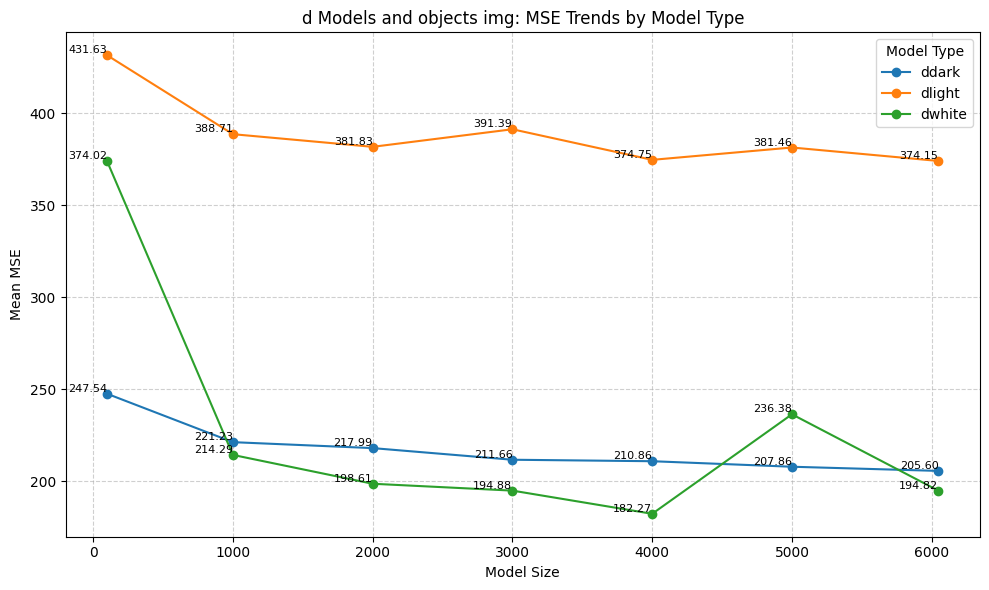

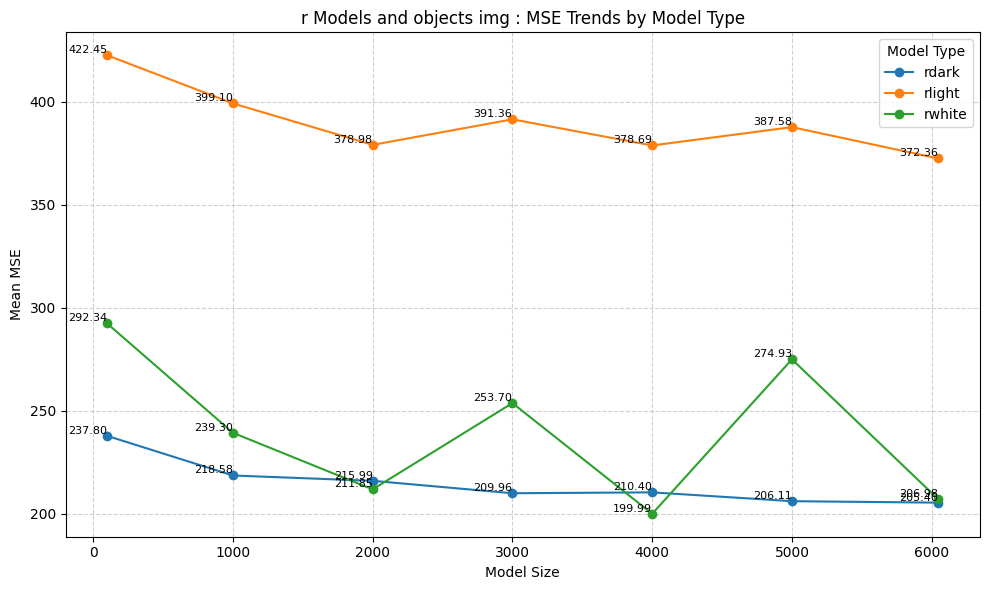

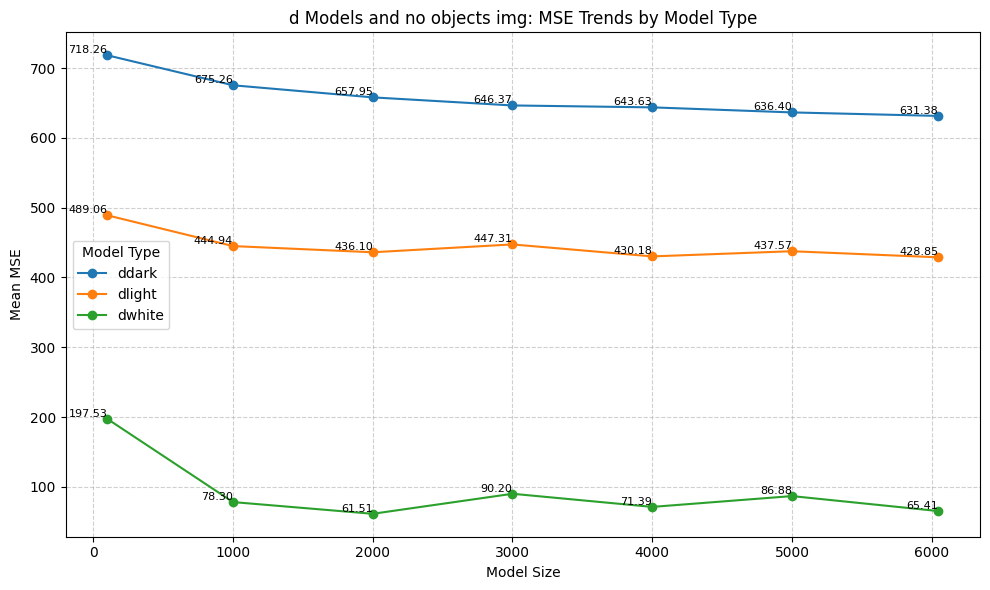

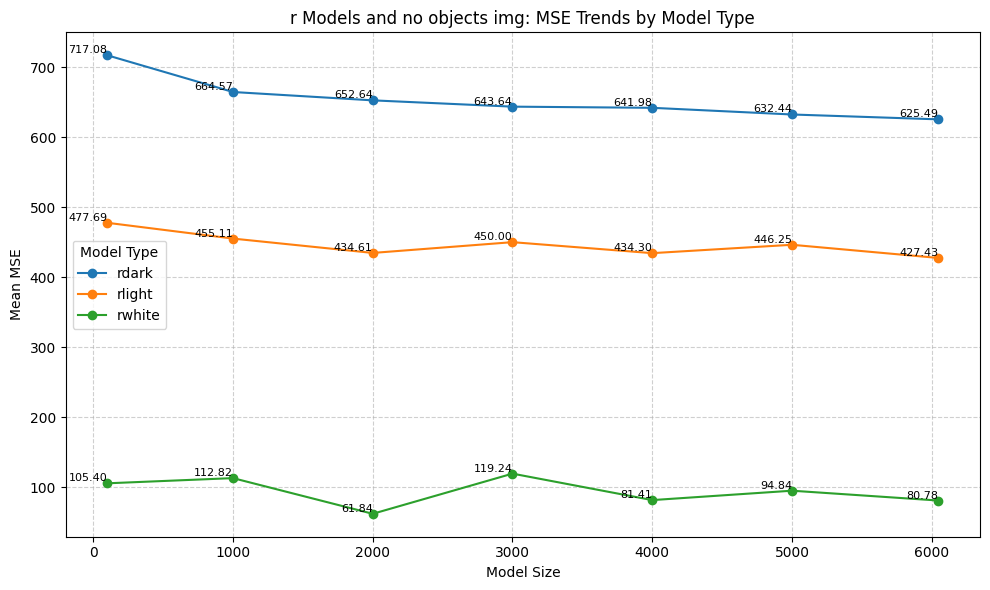

In [15]:
# グラフ描画
plot_mse_trends(d_model_paths, d_yes_mse_lists, 'd Models and objects img: MSE Trends by Model Type')
plot_mse_trends(r_model_paths, r_yes_mse_lists, 'r Models and objects img : MSE Trends by Model Type')
plot_mse_trends(d_model_paths, d_no_mse_lists, 'd Models and no objects img: MSE Trends by Model Type')
plot_mse_trends(r_model_paths, r_no_mse_lists, 'r Models and no objects img: MSE Trends by Model Type')